## Data Augmentation

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
import keras

In [9]:
# (train_ds, val_ds, test_ds), metadata = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#     with_info = True,
#     as_supervised=True,
# )


In [10]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


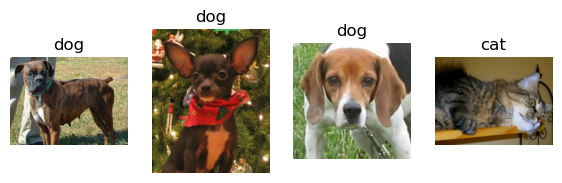

In [13]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7,8))

for x in range(4):
    image, label = next(train_iter)
    fig.add_subplot(1, 4, x+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(get_label_name(label))

### First Example

#### Resize and Rescale

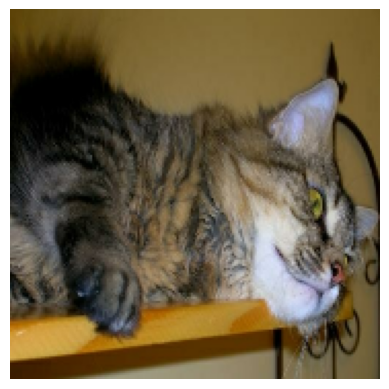

In [14]:
IMG_SIZE = 180
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

#### Random rotate and flip

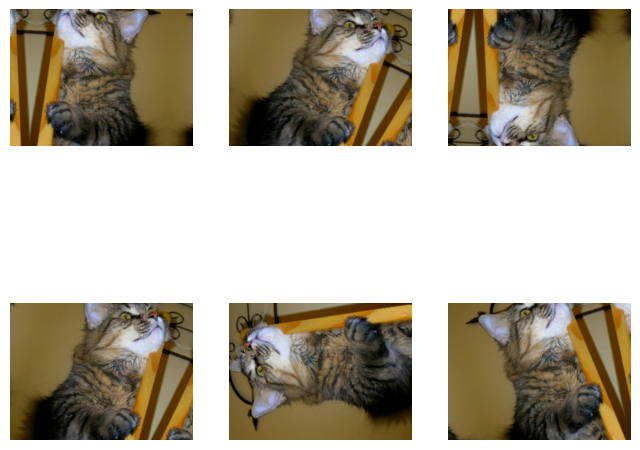

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
])

plt.figure(figsize=(8,7))
for i in range(6):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(augmented_image.numpy()/255)
    plt.axis('off')

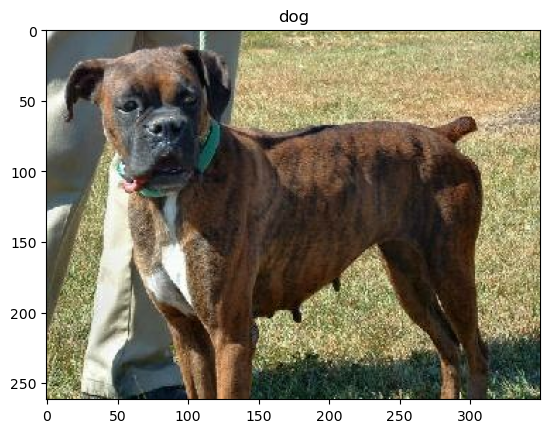

In [19]:
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label));

In [28]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')

#### Flip left to right

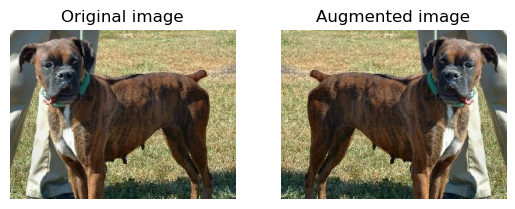

In [21]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale

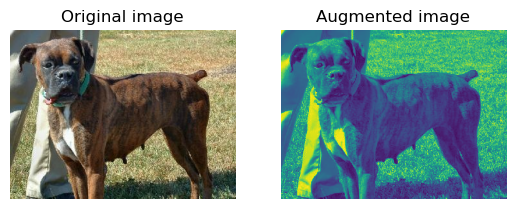

In [22]:
grayscale = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscale))

#### Adjusting the saturation

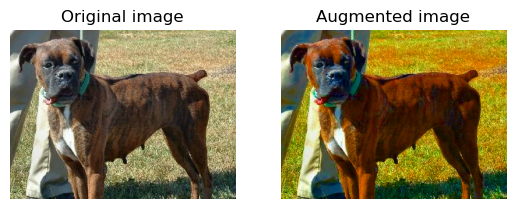

In [24]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Adjusting the brightness

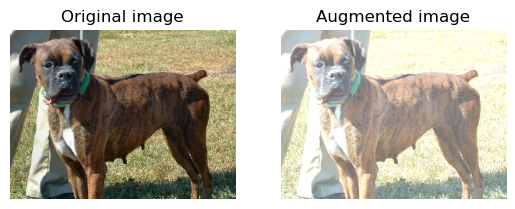

In [29]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Central Crop

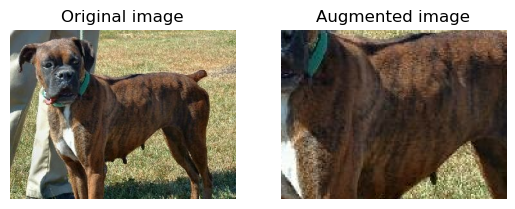

In [31]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### 90-degree rotation

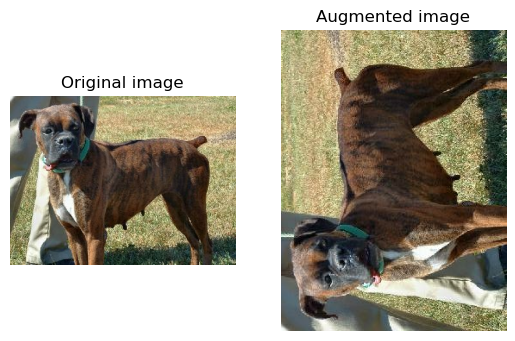

In [33]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### Applying random brightness

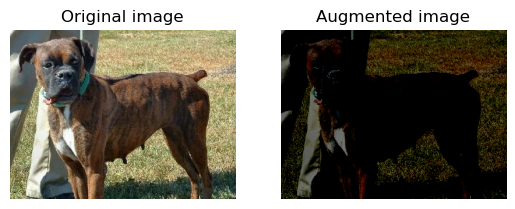

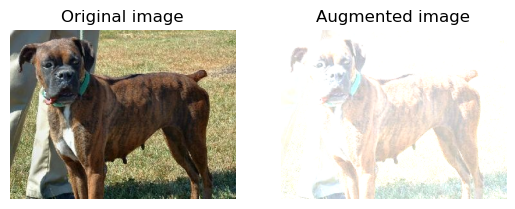

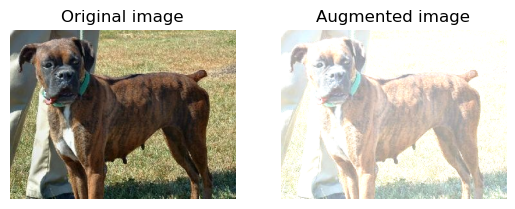

In [34]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

## Dropout

**Figure 1**
![](https://velog.velcdn.com/images/nochesita/post/8f8a2c9e-dfa8-4417-86ae-18d27a07b177/image.png)

 * (a)는 Standard Neural Net(FC layer)으로, 모든 노드가 연결되어 있습니다.
 * (b)는 Dropout을 적용한 Neural Net으로, 무작위로 노드가 끊어져있습니다.\
    $\rightarrow$ 무작위로 노드를 끊음으로써 과적합 방지를 할 수 있습니다.
 * Mini-batch학습을 시킬 때마다 활용되는 node들의 평균을 이용합니다.

**Figure 2**
![](https://velog.velcdn.com/images/nochesita/post/5cbbf9b1-a445-4d6c-998d-6bf2bb3c51ce/image.png)

 `-` 그렇다면 test시 노드들은 어떻게 적용이 될까요?
 * train에서는 확률 $p$에 의해 노드에 연결될 수도, 안될 수도 있습니다.
 * test에서는 각 노드의 가중치에 확률을 곱한 $pw$를 가중치로 사용합니다.\
   (이 부분이 이해가 잘...)
   

**Figure 3**
![](https://velog.velcdn.com/images/nochesita/post/d1ce6ed7-d7c1-4282-aab7-62852ecb81f8/image.png)

 * 레이어 : $l \in \left\{1,, ... , L\right\}$
 * $z^{(l)}$ : $l$의 출력 벡터
 * $y^{(l)}$ : $l$의 입력 벡터
 * $W^{(l)}$ : $l$의 가중치(weight)행렬
 * $b^{(l)}$ : $l$의 편향(bias) 벡터

`-` Forward Propagation \
$z_i^{(l+1)} = w_i^{(l+1)}y^l + b_i^{(l+1)}$ , $y_i^{(l+1)} = f(z_i^{(l+1)})$ ($f$ : Activation Function)


`-` Dropout
* $r_j^{(l)} \sim Bernoulli(p)$
* $\tilde{y}^{(l)} = r^{(l)}y^{(l)}$
* $z_i^{(l+1)} = w_i^{(l+1)}\tilde{y}^l + b_i^{(l+1)}$
* $z_i^{(l+1)} = w_i^{(l+1)}y^l + b_i^{(l+1)}$

## Dropconnect

![](https://d3i71xaburhd42.cloudfront.net/1e4696b88ab6b85bbeaccee4fdc38ca442414c44/2-Figure1-1.png)

* Dropout의 일반화
* Dropout은 각 layer의 node 중 일부 node의 activation을 0으로 만들어서 모델을 경량화 시켰다면, Dropconnect는 가중치(weight)를 0으로 만들어 모델을 경량화 시킵니다.

`-` Motivation
 * input : $v = [v_1, v_2, ... , v_n]^T$
 * output : $r = [r_1, r_2, ... , r_d]^T$
 * weight : $W$(of size $d$ X $n$)
 * $r = a(u) = a(Wv)$

### Regularization

#### MSE

$\begin{align} 
	E(MSE) & =E\left[(Y-\hat{Y})^2|X\right]\\ 
        & =E\left(Y^2-2Y\hat{Y}+\hat{Y}^2 |X\right)\\ 
        & = \sigma^2  + \left\{E(\hat{Y}) - \hat{Y} \right\}^2\\
        & = \sigma^2 + \text{Bias}\left(\hat{Y}\right) + \text{Var}(\hat{Y})
\end{align}$

$\hat{\beta}^{\text{LS}} = \underset{\beta}\arg\min \left\{\displaystyle\sum_{i=1}^{n} (y-x_i\beta)^2\right\}$\
$\Rightarrow \hat{\beta}^{\text{LS}} : \text{unbiased estimator}$\
$\Rightarrow$ 아이디어 : Bias가 올라가더라도 Variance를 더 낮출 수 있지 않을까?

$$\hat{y} = \beta_1x_1 + \beta_2x_2 + ... + \beta_{p}x_p$$ $$\text{or}$$  $$\hat{y} = \beta_1x + \beta_2x^2 + ... + \beta_{p}x^p$$

### Ridge

$L(\beta)=\underset{\beta}\min \displaystyle\sum_{i=1}^{n} (y_i-\hat{y}_i)^2 + \lambda \displaystyle\sum_{j=1}^{p} \beta_j^2 (\lambda : \text{hyper parameter})$

`-` if) $\lambda = \infty$\
$\Rightarrow \beta_k \approx 0(1 \leqq k \leqq p)$\
$\Rightarrow \text{Underfitting}$

`-` if) $\lambda=0$\
$\Rightarrow \text{Overfitting(LSE)}$

### Lasso

$L(\beta) = \underset{\beta}\arg\min \left\{\displaystyle\sum_{i=1}^{n}(y_i-\hat{y})^2+\lambda\displaystyle\sum_{j=1}^{p}\vert \beta_j\vert\right\}$

`-` if) $\lambda = \infty$\
$\Rightarrow \beta_k \approx 0(1 \leqq k \leqq p)$\
$\Rightarrow \text{Underfitting}$


`-` if) $\lambda=0$\
$\Rightarrow \text{Overfitting(LSE)}$

### Visualization

$\begin{align}
    MSE(\beta_1, \beta_2) & = \sum_{i=1}^{n} (y_i-\beta_1x_{i1}-\beta_2x_{i2})^2 \\
    & = \sum_{i=1}^{n} y_i^2 - 2\sum_{i=1}^{n}y_i(\beta_1x_{i1}+\beta_2x_{i2}) + \sum_{i=1}^{n}(\beta_1x_{i1} + \beta_2x_{i2})^2 \\
    & = \sum_{i=1}^{n} y_i^2 - 2(\sum_{i=1}^{n} y_ix_{i1}) - 2(\sum_{i=1}^{n} y_ix_{i2}) + \sum_{i=1}^{n}(\beta_1^2x_{i1}^2 + \beta_2^2x_{i2}^2 + 2\beta_1\beta_2x_{i1}x_{i2}) \\
    & = (\sum_{i=1}^{n} x_{i1})^2\beta_1^2+(\sum_{i=1}^{n} x_{i2})^2\beta_2^2 + 2(\sum_{i=1}^{n} x_{i1}x_{i2})\beta_1\beta_2-2(\sum_{i=1}^{n}y_ix_{i1})\beta_1-2(\sum_{i=1}^{n}y_ix_{i2})\beta_2 + \sum_{i=1}^n y_i^2 \\
    & = A\beta_1^2 + B\beta_1\beta_2 + C\beta_2^2 + D\beta_1 + E\beta_2 + F
\end{align}$

`-` 판별식
 * $B^2-4AC = 0$ : 포물선
 * $B^2-4AC > 0$ : 쌍곡선
 * $B^2-4AC < 0$ : 타원
 * $B=0, C=0$    : 원

$\begin{align}
    B^2-4AC & = \Big(2\sum_{i=1}^{n}x_{i1}x_{i2}\Big)^2 - 4\Big(\sum_{i=1}^{n} x_{i1}^2\Big)\Big(\sum_{i=1}^{n} x_{i2}^2\Big) \\
    & = 4\left\{\Big(\sum_{i=1}^{n} x_{i1}x_{i2}\Big)^2-\Big(\sum_{i=1}^{n} x_{i1}^2\Big)\Big(\sum_{i=1}^{n} x_{i2}^2\Big)\right\} < 0
\end{align}$ 


By Cauchy - Shwartz inequality

![](https://i.stack.imgur.com/0fPcu.png)
출처:https://stats.stackexchange.com/questions/587492/geometrical-interpretation-of-why-cant-ridge-regression-shrink-coefficients-to

 * $\hat{\beta}^{\text{LSE}}$가 규제하는 범위 안에 들어와 있다면 $\hat{\beta}^{\text{LSE}}$ = $\hat{\beta}^{\text{Ridge}}$ or $\hat{\beta}^{\text{LSE}}$ = $\hat{\beta}^{\text{Lasso}}$ 